In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("glove_emg1.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,0,-1,-5,-4,3,7,3,1,0,1,2,3,4
1,0,-3,0,2,-3,1,0,0,0,1,2,3,4
2,-2,-2,-2,-3,-4,-9,-4,-2,0,1,2,3,4
3,-1,0,-4,-2,1,0,0,-1,0,1,2,3,4
4,1,3,6,1,2,-1,-1,-2,0,1,2,3,4


In [4]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

In [5]:
df = data.copy(deep=True)

<AxesSubplot:>

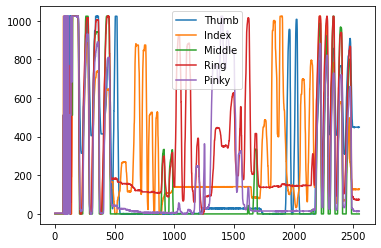

In [6]:
df[finger_names].plot()

<AxesSubplot:>

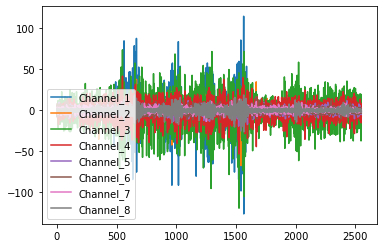

In [7]:
df[myo_cols].plot()

In [8]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Middle     Ring         0.766536
Thumb      Middle       0.747582
Channel_1  Channel_8    0.699846
Middle     Pinky        0.692025
Ring       Pinky        0.673060
Channel_3  Channel_4    0.619397
Channel_1  Channel_2    0.612738
Channel_6  Channel_7    0.592636
Index      Middle       0.588362
Channel_5  Channel_6    0.578235
dtype: float64


# Making a full hand baseline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 321.477702
Train MAE: 265.343966
Test RMSE: 330.991692
Test MAE: 271.665981


-0.043335502554749404

In [10]:
X

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,0,-1,-5,-4,3,7,3,1
1,0,-3,0,2,-3,1,0,0
2,-2,-2,-2,-3,-4,-9,-4,-2
3,-1,0,-4,-2,1,0,0,-1
4,1,3,6,1,2,-1,-1,-2
...,...,...,...,...,...,...,...,...
2545,2,8,19,8,1,1,0,1
2546,-6,-17,11,5,-4,-3,-3,-3
2547,-2,2,-38,-9,-6,-2,-3,-3
2548,4,18,14,-16,1,1,-2,0


In [11]:
y

,Thumb,Index,Middle,Ring,Pinky
0,0,1,2,3,4
1,0,1,2,3,4
2,0,1,2,3,4
3,0,1,2,3,4
4,0,1,2,3,4
...,...,...,...,...,...
2545,449,126,0,73,12
2546,449,126,0,73,12
2547,449,126,0,75,15
2548,449,126,0,75,15


# Making a baseline Neural Network

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [13]:
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = abs(df[x_cols])
y = df.drop(x_cols,1)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
# Fit the scaler on the training set.
train_X = emg_scaler.fit_transform(train_X)
train_y = rel_hand_scaler.fit_transform(train_y)
# Scale the output data.
test_X = emg_scaler.transform(test_X)
test_y = rel_hand_scaler.transform(test_y)

In [14]:
model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(5,activation='linear'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/200
60/60 [==============================] - 12s 8ms/step - loss: 1.0171 - val_loss: 0.9989
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 1.0412 - val_loss: 0.9988
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9735 - val_loss: 0.9904
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9690 - val_loss: 0.9853
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9112 - val_loss: 0.9820
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9625 - val_loss: 0.9872
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9591 - val_loss: 0.9862
Epoch 8/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9213 - val_loss: 0.9872
Epoch 9/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9703 - val_loss: 0.9866
Epoch 10/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9190 - val_loss: 0.9838
Epoch 11

60/60 [==============================] - 0s 3ms/step - loss: 0.7703 - val_loss: 1.1180
Epoch 84/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7453 - val_loss: 1.1180
Epoch 85/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7641 - val_loss: 1.1253
Epoch 86/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7724 - val_loss: 1.1123
Epoch 87/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7955 - val_loss: 1.1217
Epoch 88/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7595 - val_loss: 1.1304
Epoch 89/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7641 - val_loss: 1.1343
Epoch 90/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7479 - val_loss: 1.1314
Epoch 91/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7716 - val_loss: 1.1547
Epoch 92/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7247 - val_loss: 1.1421
Epoch 93/200


In [16]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

20/20 [==============================] - 0s 1ms/step - loss: 1.2703


1.27034330368042

Note that using wrist as the rel_point gives 0.10, which was a lower loss than using the palm

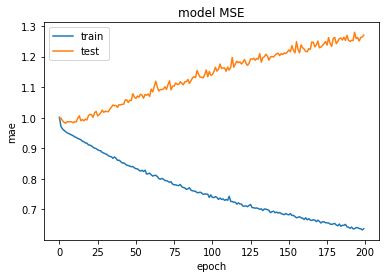

In [17]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
prediction = model.predict(train_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.28612483 -0.46097428 -0.4711598  -0.17373185 -0.43777287]
 [ 0.02469052 -0.19453368  0.08335494  0.1557589  -0.01234402]
 [ 1.6231103   0.9591876   1.6538011   1.2883829   1.4805518 ]
 ...
 [ 0.0763234   0.38845506 -0.31860504 -0.3604068  -0.3290093 ]
 [-0.36356026 -0.45302275 -0.38810012 -0.3734477  -0.19198875]
 [-0.87035286 -0.5924766  -0.88559395 -1.1502371  -0.9436682 ]]
MSE:  61185.916736092324
RMSE:  247.35787178922024
MAE:  189.21290110653973


In [21]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.14663123 -0.0531697   0.16890004  0.5139023   0.35994947]
 [-1.0913543   0.54074144 -0.4956152  -0.7407663  -0.65195745]
 [-0.00200631 -0.0191052  -0.41184548 -0.59524155 -0.55048776]
 ...
 [ 0.8054397   0.81376374  1.3414766   1.4204106   0.9444859 ]
 [-0.70647365 -0.294825   -0.29626328  0.04770265  0.33818102]
 [-0.3261639  -0.07326695 -0.2682887  -0.51539207  0.08473124]]
MSE:  127371.32783329661
RMSE:  356.8911988734054
MAE:  278.73978361394427


# Plot the predicted vs ground truth

### Save the model and the scalers

In [22]:
import joblib

model_name = "NNRel-60secs-FULL-StanScaled"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNRel-60secs-FULL-StanScaled-EMG.gz']

In [24]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

array([[-1406.4491 ,  -756.34503, -1688.6583 , -1905.7979 ,    98.17011]],
      dtype=float32)

In [26]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.14663123 -0.0531697   0.16890004  0.5139023   0.35994947]
 [-1.0913543   0.54074144 -0.4956152  -0.7407663  -0.65195745]
 [-0.00200631 -0.0191052  -0.41184548 -0.59524155 -0.55048776]
 ...
 [ 0.8054397   0.81376374  1.3414766   1.4204106   0.9444859 ]
 [-0.70647365 -0.294825   -0.29626328  0.04770265  0.33818102]
 [-0.3261639  -0.07326695 -0.2682887  -0.51539207  0.08473124]]
MSE:  127371.32783329661
RMSE:  356.8911988734054
MAE:  278.73978361394427


# LSTMs

In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import LSTM

In [29]:
y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df[y_cols]
X = df[x_cols]

In [30]:
def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X)

In [31]:
Xs.shape

(2549, 16)

In [32]:
rel_hand_scaler = MinMaxScaler()
emg_scaler = MinMaxScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]
timesteps = 2

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

In [33]:
ny.shape, nX.shape

((2549, 5), (2549, 8, 2))

In [34]:
ny

array([[0.        , 0.00097752, 0.00195503, 0.00293255, 0.00391007],
       [0.        , 0.00097752, 0.00195503, 0.00293255, 0.00391007],
       [0.        , 0.00097752, 0.00195503, 0.00293255, 0.00391007],
       ...,
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.1260997 , 0.        , 0.07331378, 0.01466276]],
      dtype=float32)

In [35]:
rel_hand_scaler.transform(y)

array([[0.        , 0.00097752, 0.00195503, 0.00293255, 0.00391007],
       [0.        , 0.00097752, 0.00195503, 0.00293255, 0.00391007],
       [0.        , 0.00097752, 0.00195503, 0.00293255, 0.00391007],
       ...,
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.12316716, 0.        , 0.07331378, 0.01466276],
       [0.43890518, 0.12609971, 0.        , 0.07331378, 0.01466276]])

In [36]:
y.head()

,Thumb,Index,Middle,Ring,Pinky
0,0,1,2,3,4
1,0,1,2,3,4
2,0,1,2,3,4
3,0,1,2,3,4
4,0,1,2,3,4


In [37]:
Xs

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_1_p1,Channel_2_p1,Channel_3_p1,Channel_4_p1,Channel_5_p1,Channel_6_p1,Channel_7_p1,Channel_8_p1
1,0.0,-3.0,0.0,2.0,-3.0,1.0,0.0,0.0,0.0,-1.0,-5.0,-4.0,3.0,7.0,3.0,1.0
2,-2.0,-2.0,-2.0,-3.0,-4.0,-9.0,-4.0,-2.0,0.0,-3.0,0.0,2.0,-3.0,1.0,0.0,0.0
3,-1.0,0.0,-4.0,-2.0,1.0,0.0,0.0,-1.0,-2.0,-2.0,-2.0,-3.0,-4.0,-9.0,-4.0,-2.0
4,1.0,3.0,6.0,1.0,2.0,-1.0,-1.0,-2.0,-1.0,0.0,-4.0,-2.0,1.0,0.0,0.0,-1.0
5,2.0,-2.0,-2.0,4.0,-2.0,2.0,2.0,-2.0,1.0,3.0,6.0,1.0,2.0,-1.0,-1.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,2.0,8.0,19.0,8.0,1.0,1.0,0.0,1.0,2.0,-1.0,-11.0,-10.0,2.0,0.0,0.0,0.0
2546,-6.0,-17.0,11.0,5.0,-4.0,-3.0,-3.0,-3.0,2.0,8.0,19.0,8.0,1.0,1.0,0.0,1.0
2547,-2.0,2.0,-38.0,-9.0,-6.0,-2.0,-3.0,-3.0,-6.0,-17.0,11.0,5.0,-4.0,-3.0,-3.0,-3.0
2548,4.0,18.0,14.0,-16.0,1.0,1.0,-2.0,0.0,-2.0,2.0,-38.0,-9.0,-6.0,-2.0,-3.0,-3.0


In [39]:
df.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,0,-1,-5,-4,3,7,3,1,0,1,2,3,4
1,0,-3,0,2,-3,1,0,0,0,1,2,3,4
2,-2,-2,-2,-3,-4,-9,-4,-2,0,1,2,3,4
3,-1,0,-4,-2,1,0,0,-1,0,1,2,3,4
4,1,3,6,1,2,-1,-1,-2,0,1,2,3,4


In [40]:
train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [41]:
train_X.shape, train_y.shape

((2049, 8, 2), (2049, 5))

## Simple RNN Arc

In [42]:
model = Sequential()
# 8 Features and 2 timesteps
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))

model.compile(loss='mse', optimizer='adam')

In [43]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
29/29 - 4s - loss: 0.0774 - val_loss: 0.2149
Epoch 2/50
29/29 - 0s - loss: 0.0783 - val_loss: 0.2520
Epoch 3/50
29/29 - 0s - loss: 0.0695 - val_loss: 0.2400
Epoch 4/50
29/29 - 0s - loss: 0.0707 - val_loss: 0.2420
Epoch 5/50
29/29 - 0s - loss: 0.0701 - val_loss: 0.2418
Epoch 6/50
29/29 - 0s - loss: 0.0698 - val_loss: 0.2417
Epoch 7/50
29/29 - 0s - loss: 0.0696 - val_loss: 0.2418
Epoch 8/50
29/29 - 0s - loss: 0.0694 - val_loss: 0.2418
Epoch 9/50
29/29 - 0s - loss: 0.0692 - val_loss: 0.2418
Epoch 10/50
29/29 - 0s - loss: 0.0690 - val_loss: 0.2418
Epoch 11/50
29/29 - 0s - loss: 0.0689 - val_loss: 0.2418
Epoch 12/50
29/29 - 0s - loss: 0.0688 - val_loss: 0.2418
Epoch 13/50
29/29 - 0s - loss: 0.0686 - val_loss: 0.2418
Epoch 14/50
29/29 - 0s - loss: 0.0685 - val_loss: 0.2419
Epoch 15/50
29/29 - 0s - loss: 0.0684 - val_loss: 0.2419
Epoch 16/50
29/29 - 0s - loss: 0.0684 - val_loss: 0.2419
Epoch 17/50
29/29 - 0s - loss: 0.0683 - val_loss: 0.2419
Epoch 18/50
29/29 - 0s - loss: 0.0682 - 

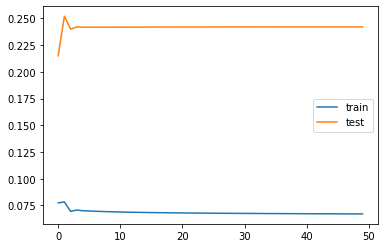

In [44]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [45]:
mea = model.evaluate(test_X, test_y)
mea

16/16 [==============================] - 0s 2ms/step - loss: 0.2420


0.24198400974273682

## Longer Timesequence RNN

In [19]:
df = pd.read_csv("glove_emg1.csv")

y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


# Get rid of the [1,2,3,4,5]s from then the labeller was breaking
df = df.iloc[90:]

# Rectify by taking the absolute value
df[x_cols] = abs(df[x_cols])

# Scale values
df[x_cols] = df[x_cols] / 128
df[y_cols] = df[y_cols] / 1024

timesteps = 20

X = df[x_cols]
y = df[y_cols]

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

nX = Xs.values
ny = y.values

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [33]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8, 64)             21760     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 14)                462       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [34]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=True)

Epoch 1/50
27/27 [==============================] - 3s 30ms/step - loss: 0.0866 - val_loss: 0.2439
Epoch 2/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0730 - val_loss: 0.2284
Epoch 3/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0674 - val_loss: 0.2076
Epoch 4/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0644 - val_loss: 0.2103
Epoch 5/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0627 - val_loss: 0.2025
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0671 - val_loss: 0.2166
Epoch 7/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0612 - val_loss: 0.1995
Epoch 8/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0617 - val_loss: 0.2119
Epoch 9/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0626 - val_loss: 0.2091
Epoch 10/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0603 - val_loss: 0.2049
Epoch 11/50
27/27 

16/16 [==============================] - 0s 3ms/step - loss: 0.2262


0.2262035459280014

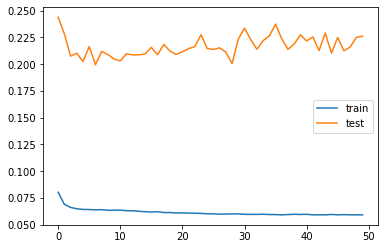

In [35]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse


In [36]:
model.predict(test_X) * 1024

array([[161.95796, 485.0192 , 107.96066, 250.10666,  89.73342],
       [163.40512, 463.0624 , 114.78941, 273.15042, 104.81974],
       [188.39763, 430.44257, 124.30263, 290.2637 , 123.257  ],
       ...,
       [123.79932, 167.61304,  49.03673, 325.2647 , 258.3017 ],
       [106.44986, 157.47452,  41.1361 , 319.87213, 259.42853],
       [ 76.38955, 151.47601,  35.63321, 325.263  , 258.43637]],
      dtype=float32)

## Plot of predicted vs truth

In [37]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = train_preds * 1024
# Scaling back the goals
train_goal = train_y * 1024

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = test_preds * 1024
# Scaling back the goals
test_goal = test_y * 1024

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

Train MSE:  61367.613
Train RMSE:  247.72487
Train MAE:  181.92528

Test MSE:  237191.62
Test RMSE:  487.02322
Test MAE:  379.7682


In [38]:
train_preds_df = pd.DataFrame(train_preds, columns=y_cols)
train_goals_df = pd.DataFrame(train_goal, columns=y_cols)

In [39]:
y_cols_pred = []
for i in y_cols:
    y_cols_pred.append(i+"_pred")
    
preds = pd.DataFrame(train_preds, columns=y_cols_pred)
goal = pd.DataFrame(train_goal, columns=y_cols)
vis = pd.concat([preds, goal], axis=1)

<AxesSubplot:>

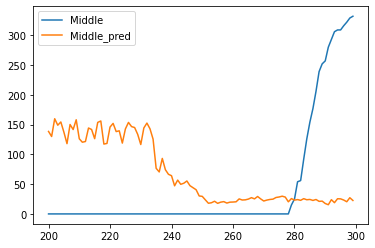

In [40]:
vis[['Middle','Middle_pred']].iloc[200:300].plot()

# Simple RNN

In [44]:
from keras.layers import SimpleRNN

In [45]:
df = pd.read_csv("glove_emg1.csv")

y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


# Get rid of the [1,2,3,4,5]s from then the labeller was breaking
df = df.iloc[90:]

# Rectify by taking the absolute value
df[x_cols] = abs(df[x_cols])

# Scale values
df[x_cols] = df[x_cols] / 128
df[y_cols] = df[y_cols] / 1024

timesteps = 20

X = df[x_cols]
y = df[y_cols]

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

nX = Xs.values
ny = y.values

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [46]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(SimpleRNN(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8, 64)             5440      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 14)                462       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

In [47]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=True)

Epoch 1/50
27/27 [==============================] - 7s 49ms/step - loss: 0.2641 - val_loss: 0.2452
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 0.1075 - val_loss: 0.2355
Epoch 3/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0827 - val_loss: 0.2336
Epoch 4/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0784 - val_loss: 0.2266
Epoch 5/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0744 - val_loss: 0.2337
Epoch 6/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0707 - val_loss: 0.2222
Epoch 7/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0685 - val_loss: 0.2198
Epoch 8/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0687 - val_loss: 0.2156
Epoch 9/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0692 - val_loss: 0.2220
Epoch 10/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0635 - val_loss: 0.2111
Epoch 11/

16/16 [==============================] - 0s 4ms/step - loss: 0.2305


0.2305465191602707

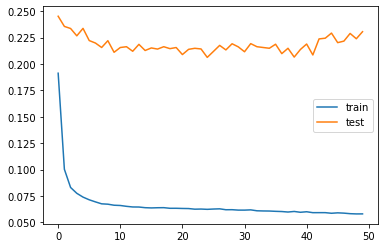

In [48]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse

In [49]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = train_preds * 1024
# Scaling back the goals
train_goal = train_y * 1024

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = test_preds * 1024
# Scaling back the goals
test_goal = test_y * 1024

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

Train MSE:  58628.78
Train RMSE:  242.1338
Train MAE:  175.85435

Test MSE:  241745.53
Test RMSE:  491.67624
Test MAE:  382.79385
